# Test challenge

This notebook corresponds to the *"Super bowl"* section of the test challenge

The statement is as follows:


<cite>
As you might know, the year is divided in quarters, here at the company, even though each day counts, we put a lot of effort to perform and succeed during the Q4 (October, November, and December). 
What's special about this? Black Friday week! (and holidays, of course). You will find in the file below the historical data from 2016 to the beginning of October 2018. You can see all the items sold during the last 2 years and the idea is to create a model to forecast the inventory needed for November and December of 2018.
Even though the data might not be enough, do your best and justify your approach. 
</cite>

A brief research throws some insights about forecasting, including:

* "some of the highest performance time series methods are currently lstm/rnn models with sliding windows, old school logistic regression with a few tweaks and finally certain probability models" [Ref](https://medium.com/@RemiStudios/artificial-intelligence-for-inventory-management-c8a9c0c2a694)
* Additional data may improve the forecast performance. Additional data may include weather conditions, temperature, upcomming holidays, current promotions, among others.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:
df = pd.read_csv('../data/orders_report.csv')

# switch to datetime data type for date columns 
df['Orders Completed Date'] = pd.to_datetime(df['Orders Completed Date'], format='%Y-%m-%d')

# switch to float data type for numeric columns
df['Orders Payment Total'] = [float(s.replace(',','')) for s in df['Orders Payment Total']]

In [4]:
df.head()

,Orders Completed Date,Orders Email Hash,Orders Number,Variants SKU,Products Name,Line Items Quantity,Line Items Price,Material Categories Name,Material Groups Name,Orders Payment Total,Orders Currency,Shipping Address ISO Name,Purchase Locations Method
0,2018-09-21,b6efaf41cdb44733b926b23222521439,M100008562YP,p52505564,Diamonds Team Ring,1,495.0,"Solid Yellow Gold, Diamond",NaN,559.35,CAD,CANADA,offline
1,2018-09-26,bd9eabcb802d539acd17097a9963cd19,M100018185UW,p52505531,Small Hoops,1,62.0,Solid Yellow Gold,Diamond Necklace,70.06,CAD,CANADA,offline
2,2018-09-08,d6bcbdb2f3564726da36c30a96b70cba,M100041026XU,p52505523,Zodiac Ring Virgo,1,69.0,"Gold Vermeil, White Sapphire",Layered Spheres Choker,79.00,USD,UNITED STATES,online
3,2018-09-11,3468d1e012dc8bd76b95e31ecd975521,M100057929FK,p052669,Sapphire Choker Silver,1,70.0,"Sterling Silver, White Sapphire",Thumbtack Studs,87.10,CAD,CANADA,online
4,2018-09-10,95f131c2ffa9a2600df63444daabde32,M100061442OL,p52505570,Ring Sizer,1,0.0,NaN,NaN,4.00,USD,UNITED STATES,online


Let's start by applying some time series forcasting models to products

A proposed pipeline is as follows:

1. Filter data to order date, product name, and line item quantity
2. Count items sold for each product and day
3. Train different forecasting models

## Preprocessing

First, we filter data

In [567]:
df_forecasting = df[['Orders Completed Date', 'Products Name', 'Line Items Quantity']].copy()

Second, we sum items sold

In [570]:
df_forecasting_product = df_forecasting.groupby([df_forecasting['Orders Completed Date'].dt.year,\
                                                 df_forecasting['Orders Completed Date'].dt.month,\
                                                 'Products Name']).sum()

#df_forecasting_product.drop('Orders Completed Date', axis=1, inplace=True)

df_forecasting_product.index.rename(['order_year', 'order_month', 'Products Name'], inplace=True)

df_forecasting_product = df_forecasting_product.reset_index()

Third, we filter data with date > 2016

In [615]:
test = df_forecasting_product.sort_values(['order_year', 'order_month', 'Line Items Quantity'])
test = test[test['order_year'] > 2016]
test['order_date'] = test['order_year'].map(str) +'-'+ test['order_month'].map(str)
test.drop(['order_year', 'order_month'], axis=1, inplace=True)

In [616]:
test

,Products Name,Line Items Quantity,order_date
1875,BE WILD SPIKES NECKLACE,1,2017-1
1879,Beaded Hoops Old,1,2017-1
1883,Black Diamond Mini Stud,1,2017-1
1897,Blaze ring,1,2017-1
1909,Diamond Mini Studs,1,2017-1
1930,Evil Eye Necklace Blue,1,2017-1
1933,Gift $50,1,2017-1
1938,Grace Ring & Midi Ring,1,2017-1
1943,Gravity V-Midi Ring Silver,1,2017-1
1946,Heart necklace,1,2017-1


Fourth, we are ready to see what data is present in items sold for period 2017-2018.

We apply pivot and filtering operations to discard products without data on every month in the period.

In [619]:
test_pivot = test.pivot(index='order_date', columns='Products Name', values='Line Items Quantity').dropna(axis=1)

test_pivot

Products Name,360 Ring,360 Studs,Beaded Ring,Beaded Ring Rose Gold,Beaded Ring White Gold,Black Diamond Mini Studs,Black Diamonds Line Ring,Black Diamonds Line Ring Rose Gold,Diamond Mini Studs,Diamond Necklace,...,Solo Diamond Ring,Sphere Studs,Sphere Studs Rose Gold,Sphere Studs White Gold,Spheres Bracelet,Spheres Choker,Trio Ring,Twist Ring,Twist Ring Rose Gold,Twist Ring White Gold
order_date,,,,,,,,,,,,,,,,,,,,,
2017-1,8.0,7.0,67.0,22.0,23.0,3.0,5.0,9.0,1.0,30.0,...,20.0,19.0,21.0,14.0,19.0,15.0,4.0,60.0,18.0,10.0
2017-10,45.0,20.0,100.0,28.0,30.0,1.0,11.0,12.0,10.0,42.0,...,28.0,43.0,30.0,17.0,32.0,33.0,9.0,86.0,30.0,31.0
2017-11,215.0,58.0,425.0,138.0,108.0,16.0,51.0,27.0,48.0,206.0,...,99.0,160.0,63.0,85.0,88.0,68.0,39.0,446.0,112.0,126.0
2017-12,102.0,34.0,181.0,50.0,44.0,11.0,14.0,15.0,21.0,116.0,...,54.0,64.0,27.0,33.0,36.0,33.0,21.0,171.0,32.0,59.0
2017-2,47.0,18.0,79.0,36.0,34.0,2.0,6.0,7.0,4.0,32.0,...,22.0,31.0,22.0,15.0,19.0,18.0,12.0,62.0,34.0,22.0
2017-3,38.0,20.0,87.0,24.0,19.0,1.0,7.0,8.0,5.0,37.0,...,19.0,18.0,17.0,11.0,28.0,24.0,8.0,87.0,15.0,21.0
2017-4,36.0,18.0,74.0,32.0,21.0,2.0,5.0,4.0,1.0,28.0,...,29.0,32.0,14.0,12.0,28.0,20.0,4.0,60.0,18.0,12.0
2017-5,44.0,10.0,74.0,25.0,23.0,5.0,12.0,5.0,9.0,35.0,...,9.0,27.0,17.0,8.0,16.0,28.0,7.0,74.0,27.0,17.0
2017-6,33.0,12.0,88.0,21.0,18.0,2.0,5.0,4.0,7.0,21.0,...,16.0,19.0,11.0,8.0,21.0,39.0,4.0,60.0,15.0,15.0


Finally, we rank items sold by the median centrality measure.

In [574]:
test_pivot.median().sort_values().tail()

Products Name
Diamond Necklace       60.5
Diamonds Open Ring     70.0
Lotus Necklace         85.0
Twist Ring            124.0
Beaded Ring           139.5
dtype: float64

With this rank, we choose one product to test our prediction approaches. In this case, we choose the third product in the rank ('Lotus Necklace')

We also remove data in 2018-10 since we only have partial data for this month.

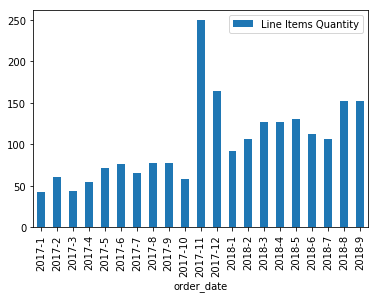

In [578]:
product_name = 'Lotus Necklace' #'Evil Eye Chain Ring Blue'

test_plot = test[test['Products Name'] == product_name].copy()

test_plot = test_plot.drop('Products Name', axis=1).set_index('order_date').drop('2018-10')

test_plot.plot(kind='bar')

## Forecast model training

The model should consider some features of the data. In particular, data is seasonal (quarters) and the aim of the model is to forecast the demand (inventory) for each item on the months of October (remember the incomplete data on this month), November and December (2018). 

Let's filter the data for our product name in the selected period of time.

In [585]:
# Filter data to the selected product and period of time
df_forecasting_product_example = df_forecasting_product[df_forecasting_product['Products Name'] == product_name].copy()
df_forecasting_product_example.drop(['Products Name'], axis=1, inplace=True)
df_forecasting_product_example = df_forecasting_product_example[df_forecasting_product_example['order_year'] > 2016]

# Process dates
df_forecasting_product_example.sort_values(['order_year', 'order_month'], inplace=True)
df_forecasting_product_example['order_date'] = df_forecasting_product_example['order_year'].map(str)\
                                                +'-'+\
                                                df_forecasting_product_example['order_month'].map(str)
df_forecasting_product_example.drop(['order_year', 'order_month'], axis=1, inplace=True)
df_forecasting_product_example.set_index(['order_date'], inplace=True)
df_forecasting_product_example.drop('2018-10', inplace=True)

In [586]:
df_forecasting_product_example

,Line Items Quantity
order_date,
2017-1,42
2017-2,60
2017-3,44
2017-4,55
2017-5,71
2017-6,76
2017-7,65
2017-8,77
2017-9,78


We plot an autocorrelogram to understand the time lags 

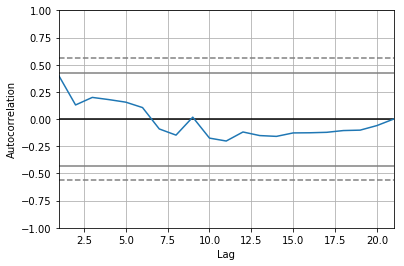

In [588]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_forecasting_product_example)

Nex, we try different models for time series prediction, including AR, ARMA, ARIMA and SARIMA

### AR

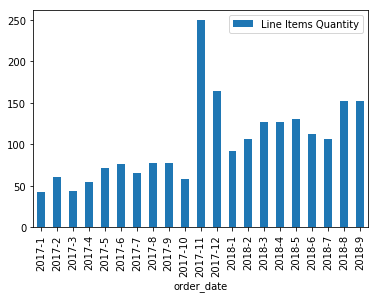

In [589]:
df_forecasting_product_example.plot(kind='bar')

In [594]:
from statsmodels.tsa.ar_model import AR

model = AR(df_forecasting_product_example)
model_fit = model.fit()

/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [593]:
model_fit.predict(21, 21)

2018-10-01    121.509596
Freq: MS, dtype: float64

### ARMA

In [595]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(df_forecasting_product_example, order=(0,1))
model_fit = model.fit(disp=False)

/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Now, let's forecast the next three months (2018-10, 2018-11, and 2018-12)

In [601]:
model_fit.forecast(3)[0]

array([114.54190456, 101.75646336, 101.75646336])

### ARIMA

In [602]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_forecasting_product_example, order=(5,1,0))
model_fit = model.fit(disp=False)

/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

In [603]:
model_fit.forecast(3)[0]

array([144.33816514, 149.16940465, 153.56411441])

### SARIMAX

In [604]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_forecasting_product_example, order=(5,1,1), seasonal_order=(1,0,0,12))
model_fit = model.fit(disp=False)

/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [605]:
forecast = model_fit.forecast(3)

forecast

2018-10-01    132.631633
2018-11-01    280.956520
2018-12-01    213.987314
Freq: MS, dtype: float64

Now, we can plot data to have an holistic view of actual and predicted values

In [554]:
import matplotlib.pyplot as plt

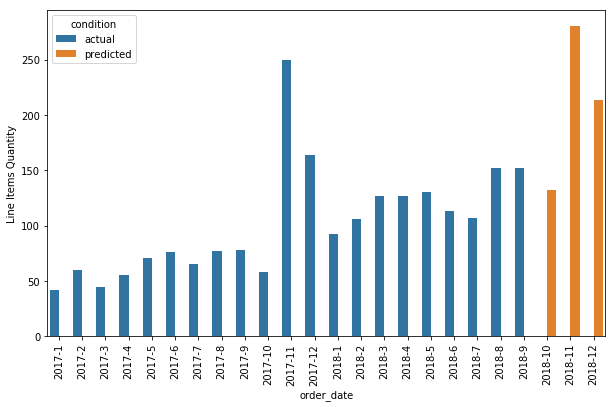

In [610]:
# Set a stadarized structure
forecast_plot = forecast.reset_index().rename({'index': 'date', 0: 'Line Items Quantity'}, axis=1)

# Process dates
forecast_plot['order_year'] = forecast_plot['date'].dt.year
forecast_plot['order_month'] = forecast_plot['date'].dt.month
forecast_plot['order_date'] = forecast_plot['order_year'].map(str) +'-'+ forecast_plot['order_month'].map(str)
forecast_plot.drop(['order_year', 'order_month', 'date'], axis=1, inplace=True)
forecast_plot.set_index('order_date', inplace=True)

# Give contitions (actual, predicted)
forecast_plot['condition'] = 'predicted'
df_forecasting_product_example['condition'] = 'actual'

# Concatenate data
data_plot = pd.concat([df_forecasting_product_example, forecast_plot]).reset_index()

# Set figure preferences and plot
plt.figure(figsize=(10,6))
plot = sns.barplot(x='order_date', y='Line Items Quantity', hue='condition', data=data_plot)
for i in plot.get_xticklabels():
    i.set_rotation(90)

### Conclusions

In this forecasting challenge, we have evaluated different approaches for time series prediction. 

This approaches involve some features such as:
* Selection of one representative product name to test predictions ('Lotus Necklace')
* Selection of a range in the time period (2017-2018)
* Use of [endogenous variables](https://www.statisticshowto.datasciencecentral.com/endogenous-variable/)
* Evaluation of statistical time series models

We evaluated the product name 'Lotus Necklace'. This product is on the top 5 median products sold in 2017.
We excluded 2016 data since only two product names have continuous data in the whole dataset ('Evil Eye Chain Ring', 'Evil Eye Chain Ring Blue').
We applied statistical time series models with only endogenous variables because of the limitations of the dataset. 

## Further analysis

An alternative approach is to enrich data by means of granular (more accurate) *location* data, such as GPS coordinates. Accurate location data may be useful to retrieve aditional ["external" data](https://blog.toolsgroup.com/en/how-not-to-use-machine-learning-in-demand-forecasting) such as weather, demographics, traffic. These data may contribute to train machine learning forecast models.